In [35]:
import collections
import os, csv, random, math
import numpy as np
import tensorflow as tf
import nltk
import time
import zipfile
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import pylab

In [30]:
filename = 'bbc-fulltext.zip'
files_to_read_for_topic = 250

batch_size = 24 # origin 128
embedding_size = 24 # origin 128
window_size = 2 # origin 4

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50
# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)
num_sampled = 32 # Number of negative examples to sample.

num_steps = 100001 # origin 100001

# We take batch_size*num_test_steps words from each document
# to compute document embeddings
num_test_steps = 100
# Number of data points to visualize
num_points = 1000 

In [26]:
tf.reset_default_graph()
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
#train_labels = tf.placeholder(tf.int64, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
# vocabulary_size, embedding_size (50000, 128)
in_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
# out_embeddings is used to lookup embeddings corresponding to contact words (labels)
out_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# 1. Compute negative sampels for a given batch of data
# Returns a [num_sampled] size Tensor
negative_samples, _, _ = tf.nn.log_uniform_candidate_sampler(train_labels, num_true=1, num_sampled=num_sampled, 
                                                           unique=True, range_max=vocabulary_size)
# 2. Look up embeddings for inputs, outputs and negative samples.
in_embed = tf.nn.embedding_lookup(in_embeddings, train_dataset)
out_embed = tf.nn.embedding_lookup(out_embeddings, tf.reshape(train_labels,[-1]))
# train_labels 有分 train_labels[][0] train_labels[][1] 放相同的資料是要避免預測自己
# tf.reshape 把兩層合在一起

negative_embed = tf.nn.embedding_lookup(out_embeddings, negative_samples) 
# 3.1. Computing the loss for the positive sample
# Exactly we compute log(sigma(v_o * v_i^T)) with this equation
loss = tf.reduce_mean(
  tf.log(
      tf.nn.sigmoid(
          tf.reduce_sum(
              tf.diag([1.0 for _ in range(batch_size)])*
              tf.matmul(out_embed,tf.transpose(in_embed)),
          axis=0)
      )
  )      
)
# 3.2. Computing loss for the negative samples
# We compute sum(log(sigma(-v_no * v_i^T))) with the following
# Note: The exact way this part is computed in TensorFlow library appears to be
# by taking only the weights corresponding to true samples and negative samples
# and then computing the softmax_cross_entropy_with_logits for that subset of weights.
# More infor at: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/ops/nn_impl.py
# Though the approach is different, the idea remains the same
loss += tf.reduce_mean(
  tf.reduce_sum(
      tf.log(tf.nn.sigmoid(-tf.matmul(negative_embed,tf.transpose(in_embed)))),
      axis=0
  )
)
# The above is the log likelihood. 
# We would like to transform this to the negative log likelihood
# to convert this to a loss. This provides us with
# L = - (log(sigma(v_o * v_i^T))+sum(log(sigma(-v_no * v_i^T))))
loss *= -1.0

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
## Calculating Word Similarities
norm = tf.sqrt(tf.reduce_sum(tf.square((in_embeddings+out_embeddings)/2.0),
                             1, keepdims=True))
normalized_embeddings = out_embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

In [21]:
def read_data(filename):
    data = []
  
    topics = ['business','entertainment','politics','sport','tech']
    with zipfile.ZipFile(filename) as z:
        parent_dir = z.namelist()[0]
        for t in topics:
            print('\tFinished reading data for topic: ',t)
            for fi in range(1,files_to_read_for_topic):
                with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                    file_string = f.read().decode('latin-1')
                    file_string = file_string.lower()
                    file_string = nltk.word_tokenize(file_string)
                    data.extend(file_string)
                
    return data

def read_test_data(filename):
    test_data = {}    
    topics = ['business','entertainment','politics','sport','tech']
    with zipfile.ZipFile(filename) as z:
        parent_dir = z.namelist()[0]
        for t in topics:
            print('\tFinished reading data for topic: ',t)            
            for fi in np.random.randint(1,files_to_read_for_topic,(10)).tolist():
                with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                    file_string = f.read().decode('latin-1')
                    file_string = file_string.lower()
                    file_string = nltk.word_tokenize(file_string)
                    test_data[t+'-'+str(fi)] = file_string

    return test_data

tStart = time.time()
print('Processing training data...')
words = read_data(filename)
print('\nProcessing testing data...')
test_words = read_test_data(filename)

print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])
for i,item in enumerate(zip(test_words.keys(),test_words.values())):
    if i<2:
        print('\nTopic',item[0])
        print('Content',item[1][:10])

tEnd = time.time()
print('Cost %.2f seconds'%(tEnd-tStart))

Processing training data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech

Processing testing data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech
Example words (start):  ['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us']
Example words (end):  ['almost', '200,000', 'people', 'are', 'registered', 'players', 'on', 'project', 'entropia', '.']

Topic business-204
Content ['bush', 'to', 'outline', "'toughest", "'", 'budget', 'president', 'bush', 'is', 'to']

Topic business-141
Content ['bmw', 'reveals', 'new', 'models', 'pipeline', 'bmw', 'is', 'preparing', 'to', 'enter']
Cost 3.19 seconds


In [22]:
def build_dataset(words): 
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)    
    data = list()
    unk_count = 0    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))   
    assert len(dictionary) == vocabulary_size

    return data, count, dictionary, reverse_dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    data = list()
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        data.append(index)
    return data

# Processining training data
data, count, dictionary, reverse_dictionary = build_dataset(words)

# Processing test data
test_data = {}
for k,v in test_words.items():
    print('Building Test Dataset for ',k,' topic')
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('test keys: ',test_data.keys())
del words  # Hint to reduce memory.
del test_words

Building Test Dataset for  business-204  topic
Building Test Dataset for  business-141  topic
Building Test Dataset for  business-68  topic
Building Test Dataset for  business-53  topic
Building Test Dataset for  business-142  topic
Building Test Dataset for  business-160  topic
Building Test Dataset for  business-236  topic
Building Test Dataset for  business-85  topic
Building Test Dataset for  business-145  topic
Building Test Dataset for  entertainment-144  topic
Building Test Dataset for  entertainment-14  topic
Building Test Dataset for  entertainment-116  topic
Building Test Dataset for  entertainment-11  topic
Building Test Dataset for  entertainment-118  topic
Building Test Dataset for  entertainment-176  topic
Building Test Dataset for  entertainment-242  topic
Building Test Dataset for  entertainment-43  topic
Building Test Dataset for  entertainment-218  topic
Building Test Dataset for  politics-128  topic
Building Test Dataset for  politics-116  topic
Building Test Dataset

In [23]:
data_index = 0

def generate_batch(data, batch_size, window_size):
    global data_index
    span = 2 * window_size + 1
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    num_samples = 2*window_size 
    for i in range(batch_size // num_samples):
        k=0      
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1 
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    
    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch(data, batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with window_size = 1:
    batch: [['sales', 'sales'], ['sales', 'sales'], ['boost', 'boost'], ['boost', 'boost'], ['time', 'time'], ['time', 'time'], ['warner', 'warner'], ['warner', 'warner']]
    labels: ['ad', 'boost', 'sales', 'time', 'boost', 'warner', 'time', 'profit']

with window_size = 2:
    batch: [['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time']]
    labels: ['ad', 'sales', 'time', 'warner', 'sales', 'boost', 'warner', 'profit']


In [24]:
test_data_index = 0

def generate_test_batch(data, batch_size):
    global test_data_index
    batch = np.ndarray(shape=(batch_size,), dtype=np.int32)    
    for bi in range(batch_size):
        batch[bi] = data[test_data_index]
        test_data_index = (test_data_index + 1) % len(data)

    return batch

test_data_index = 0
test_batch = generate_test_batch(test_data[list(test_data.keys())[0]], batch_size=8)
print('\nwith window_size = %d:' % (window_size))
print('    labels:', [reverse_dictionary[li] for li in test_batch.reshape(8)])


with window_size = 2:
    labels: ['bush', 'to', 'UNK', 'UNK', "'", 'budget', 'president', 'bush']


# CBOW Algorithm

In [28]:
tf.reset_default_graph()
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
test_labels = tf.placeholder(tf.int32, shape=[batch_size],name='test_dataset')

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                  stddev=1.0 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size],dtype=tf.float32))

mean_batch_embedding = tf.reduce_mean(tf.nn.embedding_lookup(embeddings,test_labels),axis=0)
    
# Model.
# Look up embeddings for all the context words of the inputs.
# Then compute a tensor by staking embeddings of all context words
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

# Make sure the staked embeddings have 2*window_size columns
assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

# Compute mean embeddings by taking the mean of the tensor containing the stack of embeddings
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

## Calculating Word Similarities
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

Defining 4 embedding lookups representing each word in the context
Stacked embedding size: [24, 24, 4]
Reduced mean embedding size: [24, 24]


In [29]:
cbow_loss = []
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = False # 使用GPU

tStart = time.time()
with tf.Session(config=config) as session:
    tf.global_variables_initializer().run()
    print('Initialized',time.strftime('%H:%M:%S',time.localtime()))    
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(data, batch_size, window_size)     
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)        
        average_loss += l        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000                
            print('Average loss at step %d: %f' % (step+1, average_loss))
            cbow_loss.append(average_loss)
            average_loss = 0        
        if (step+1) % 10000 == 0:
            print(time.strftime('%H:%M:%S',time.localtime()))    
            sim = similarity.eval()            
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    document_embeddings = {}
    print('Testing Phase (Compute document embeddings)')    
    for k,v in test_data.items():
        print('\tCalculating mean embedding for document ',k,' with ', num_test_steps, ' steps.')
        test_data_index = 0
        topic_mean_batch_embeddings = np.empty((num_test_steps,embedding_size),dtype=np.float32)
        
        # keep averaging mean word embeddings obtained for each step
        for test_step in range(num_test_steps):
            test_batch_labels = generate_test_batch(test_data[k],batch_size)
            batch_mean = session.run(mean_batch_embedding,feed_dict={test_labels:test_batch_labels})
            topic_mean_batch_embeddings[test_step,:] = batch_mean
        document_embeddings[k] = np.mean(topic_mean_batch_embeddings,axis=0)
        
tEnd = time.time()
print('Cost %.2f seconds'%(tEnd-tStart))

Initialized 21:27:49
Average loss at step 2000: 3.516654
Average loss at step 4000: 3.267533
Average loss at step 6000: 3.201444
Average loss at step 8000: 3.221862
Average loss at step 10000: 3.258563
21:27:56
Nearest to for: of, from, 7, in, with, over, during, burnley,
Nearest to which: die, others, mcclaren, woman, episodes, sarah, outrage, scams,
Nearest to his: an, its, economics, our, closer, the, feeling, date,
Nearest to he: it, spare, ring, ``, suing, tomorrow, bruce, but,
Nearest to had: has, will, tory, is, singles, phenomenon, as, spark,
Nearest to mr: dr, spare, peter, chris, he, francisco, adds, talked,
Nearest to a: labelled, flat, prison, host, closer, advance, the, commons,
Nearest to by: hit, stick, -, mcclaren, boss, sex, teams, tool,
Nearest to be: connected, independent, 2000, founded, funds, develop, add, increases,
Nearest to is: was, specialist, attacked, previously, dealt, had, adapted, affordable,
Nearest to not: fake, examine, hard, thought, allow, you, like

Average loss at step 62000: 3.060765
Average loss at step 64000: 3.082030
Average loss at step 66000: 3.148992
Average loss at step 68000: 3.099861
Average loss at step 70000: 3.106121
21:28:42
Nearest to for: through, over, of, by, tackling, without, or, against,
Nearest to which: assess, regional, whose, only, key, among, patrol, new,
Nearest to his: an, its, the, every, her, my, a, their,
Nearest to he: she, it, they, mr, economists, ioannidis, but, there,
Nearest to had: has, have, withdraw, by, were, oppose, doubled, prevented,
Nearest to mr: lord, woolf, ms, tricks, tony, kelly, wilson, he,
Nearest to a: an, any, his, the, my, its, tremendous, guantanamo,
Nearest to by: for, under, has, before, with, over, had, through,
Nearest to be: establish, settle, bring, keep, stand, lead, prevent, attend,
Nearest to is: was, became, stood, luck, knows, are, ankle, solve,
Nearest to not: n't, understood, delighted, apply, thought, certainly, vital, made,
Nearest to i: you, we, pretty, else,

	Calculating mean embedding for document  tech-53  with  100  steps.
	Calculating mean embedding for document  tech-243  with  100  steps.
	Calculating mean embedding for document  tech-103  with  100  steps.
Cost 77.05 seconds


## Visualizing documents with t-SNE

In [33]:
# Create a t-SNE object
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE')
# get the T-SNE manifold
doc_ids, doc_embeddings = zip(*document_embeddings.items())
two_d_embeddings = tsne.fit_transform(doc_embeddings)
print('\tDone')

Fitting embeddings to T-SNE
	Done


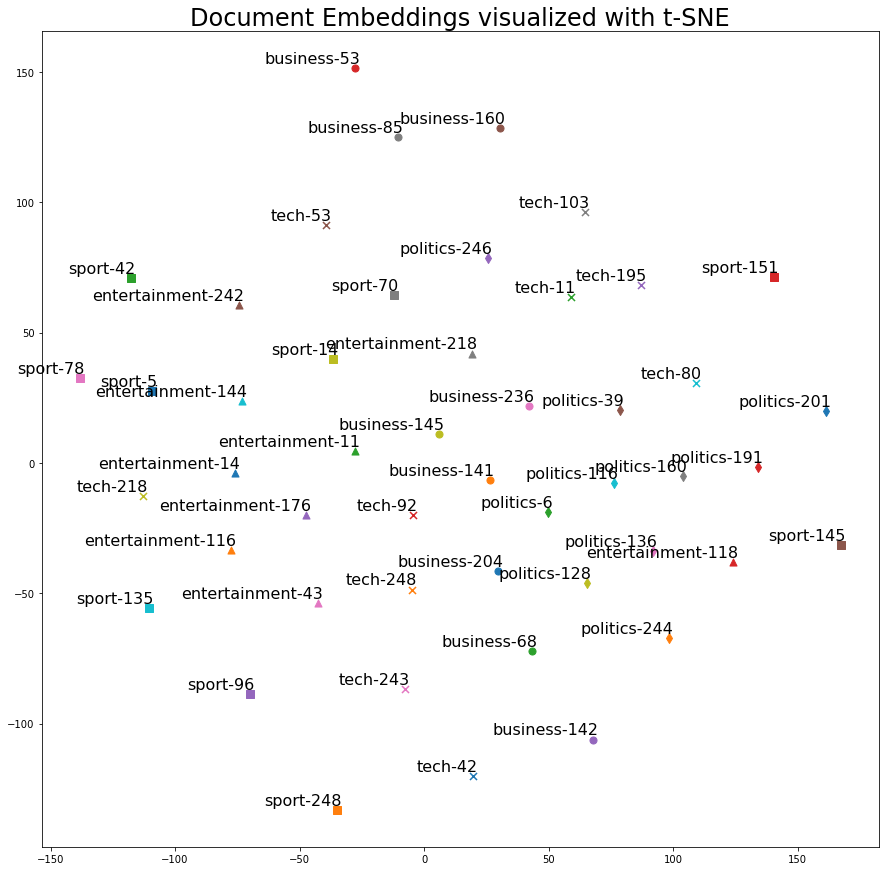

In [36]:
def plot(embeddings, labels):  
    n_clusters = 5 # number of clusters
    label_colors = [pylab.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
    label_markers = ['o','^','d','s','x']
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
    pylab.figure(figsize=(15,15))  # in inches

    def get_label_id_from_key(key):    
        if 'business' in key:
            return 0
        elif 'entertainment' in key:
            return 1
        elif 'politics' in key:
            return 2
        elif 'sport' in key:
            return 3
        elif 'tech' in key:
            return 4

  
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, cmap=label_colors[get_label_id_from_key(label)],s=50,
                  marker=label_markers[get_label_id_from_key(label)])    
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)  
    pylab.title('Document Embeddings visualized with t-SNE',fontsize=24)
    pylab.savefig('document_embeddings.png')
    pylab.show()

# Run the plotting function
plot(two_d_embeddings, doc_ids)

## Perform Document Classification

Here we first cluster the document embeddings by means of K-means. K-means is a popular and simple clustering algorithm. Then we will list what is contained in each cluster. Each cluster should roughly contain documents belonging to a single category. You can use the same information to classify an unseen document using the following steps.
1. Compute the document embeddings for test document
2. Compute K-means using all the previous documents + the new document
3. Label the new test document to be of the category most of it's neighbors belong to

In [37]:
kmeans = KMeans(n_clusters=5, random_state=43643, max_iter=10000, n_init=100, algorithm='elkan')
kmeans.fit(np.array(list(document_embeddings.values())))

# Compute items fallen within each cluster
document_classes = {}
for inp, lbl in zip(list(document_embeddings.keys()), kmeans.labels_):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)
for k,v in document_classes.items():    
    print('\nDocuments in Cluster ',k)
    print('\t',v)


Documents in Cluster  4
	 ['business-204', 'business-141', 'business-68', 'business-53', 'business-142', 'business-160', 'business-236', 'business-85', 'business-145', 'entertainment-11', 'entertainment-218', 'politics-6', 'politics-246', 'tech-218', 'tech-248', 'tech-92']

Documents in Cluster  3
	 ['entertainment-144', 'entertainment-14', 'entertainment-116', 'entertainment-176', 'entertainment-242', 'entertainment-43', 'sport-135', 'sport-5', 'sport-78']

Documents in Cluster  2
	 ['entertainment-118', 'politics-128', 'politics-116', 'politics-201', 'politics-244', 'politics-191', 'politics-39', 'politics-136', 'politics-160', 'tech-80']

Documents in Cluster  0
	 ['sport-14', 'sport-248', 'sport-42', 'sport-151', 'sport-96', 'sport-145', 'sport-70']

Documents in Cluster  1
	 ['tech-42', 'tech-11', 'tech-195', 'tech-53', 'tech-243', 'tech-103']
